In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [20]:
def get_cols(df, cols):
    return df[cols].T.values

def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

In [3]:
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')

In [4]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [5]:
workflows = df['workflow_name'].unique().tolist()
print(workflows)

hc = df.query('workflow_name == @workflows[0]')
classify = df.query('workflow_name == @workflows[1]')
onthego = df.query('workflow_name == @workflows[2]')

['Classify! Hardcore edition', 'Classify!', 'Classify on the go!']


---

In [104]:
# @todo: synchronize xlim and ylim based on min and max of whole dataframe

def plot_phot(dfs, labels, title):
    fig, fr = plt.subplots(1,4, figsize=(17,4.5))

    colors = ['xkcd:lightish blue', 'xkcd:orange']
    
    for idx, df in enumerate(dfs):
        r, g, mue_r, C = get_cols(df, ['r', 'g', 'mue_r', 'C'])

        kw = dict(s=8, alpha=0.4, color=colors[idx], label=labels[idx])

        fr[0].scatter(g-r, mue_r, **kw)
        fr[1].scatter(r, mue_r, **kw)
        fr[2].scatter(r, g-r, **kw)
        fr[3].scatter(r, C, **kw)

        fr[3].update(dict(
            ylim=(0, np.max(df_votes['C'])+0.4)
        ))

        fr[0].set_xlabel(r"$g'-r'$ [mag]")
        fr[0].set_xlim([np.min(df_votes['g']-df_votes['r'])-0.2, np.max(df_votes['g']-df_votes['r'])+0.2])

        for i in range(2):
            fr[i].set_ylim(np.min(df_votes['mue_r']), np.max(df_votes['mue_r']))
            fr[i].set_ylabel(r'$\mu_{e,r}$ [mag arcsec-2]')
            fr[i].set_ylim(fr[i].get_ylim()[::-1])

        for i in range(1, 4):
            fr[i].set_xlabel(r"$r'$ [mag]")
            fr[i].set_xlim(np.min(df_votes['r'])-1, np.max(df_votes['r'])+1)

        fr[2].set_ylabel(r"$g'-r' [mag]$")
        fr[3].set_ylabel('$C$')

    for i in range(4):
        fr[i].grid(alpha=0.3, which='both')
        fr[i].legend()

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [177]:
def plot_distr(frames, labl):
    fig, fr = plt.subplots(1,4, figsize=(17,3.5))

    for idx, frame in enumerate(frames):
        kw = dict(histtype='step', facecolor='none', lw=2, density=True, bins=15, label=labl[idx])

        fr[0].hist(frame['g']-frame['r'], **kw)
        fr[1].hist(frame['mue_r'], **kw)
        fr[3].hist(frame['Reff'], **kw)
        fr[2].hist(frame['C'], **kw)

    labels = ['g-r', 'mue_r', 'Reff', 'C']
    for i in range(4):
        fr[i].update(dict(
            xlabel=labels[i]
        ))
        fr[i].grid(alpha=0.3)
        fr[i].legend()
    fr[0].update(dict(ylabel='normalized count'))
    fig.tight_layout()
    plt.show()
    

### Make plots like Venhola2018 for various data subsets:

In [ ]:
t0cols = get_column_names('T0', df_votes)

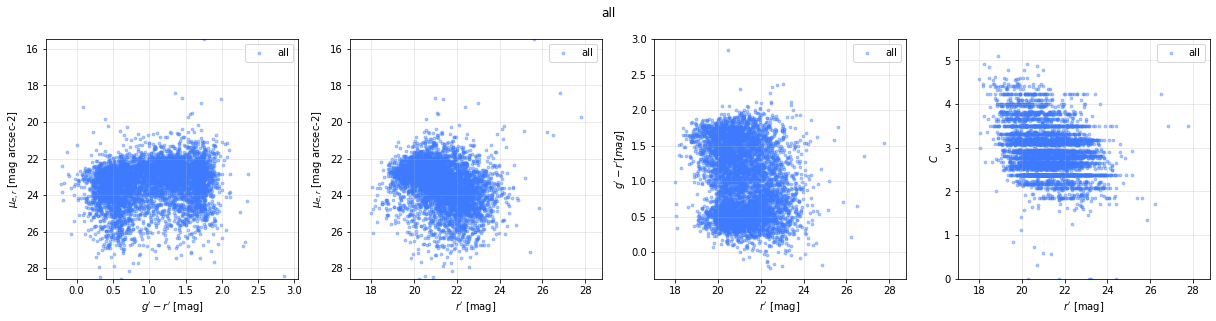

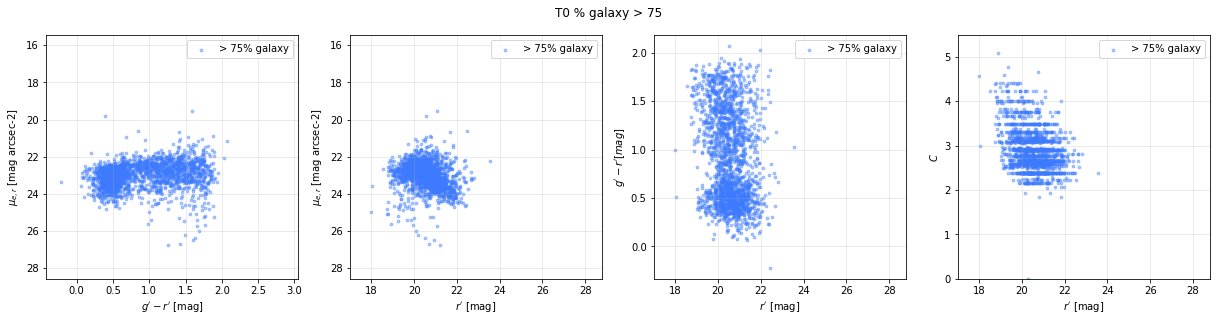

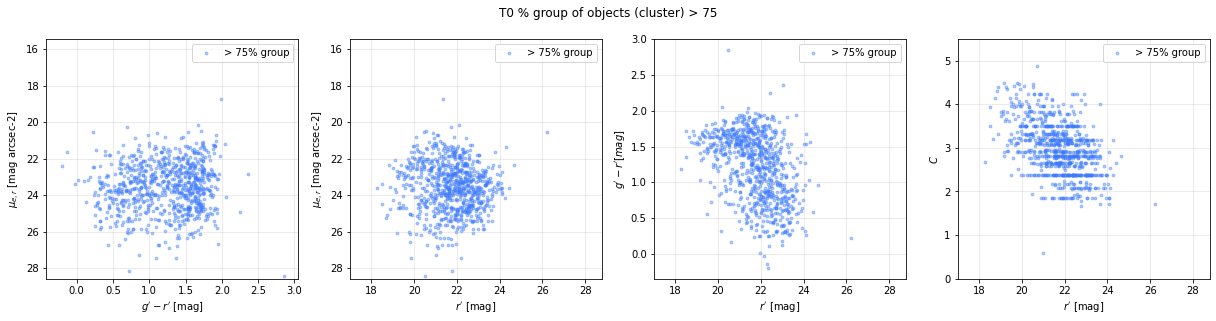

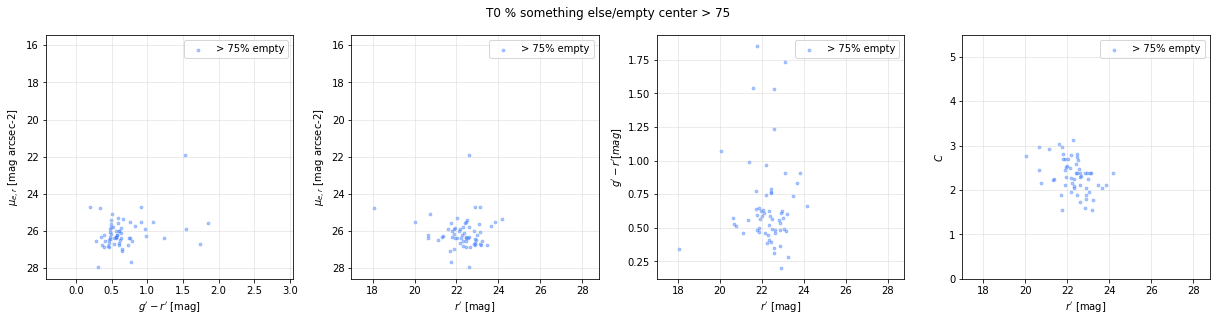

In [113]:
plot_phot([df_votes], ['all'], 'all')
labels = ['galaxy', 'group', 'empty']
for idx, ans in enumerate(t0cols[1:]):
    ans_str = '`{}`'.format(ans)
    plot_phot([df_votes[df_votes[ans] > 75]], ['> 75% {}'.format(labels[idx])], '{} > 75'.format(ans))

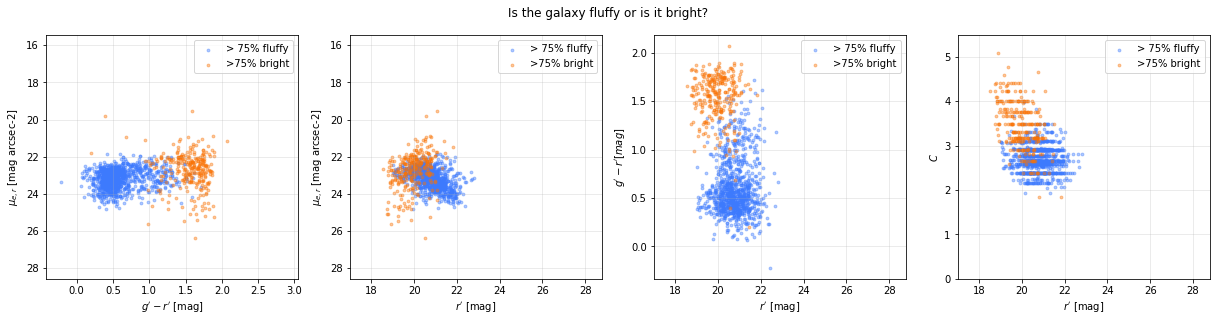

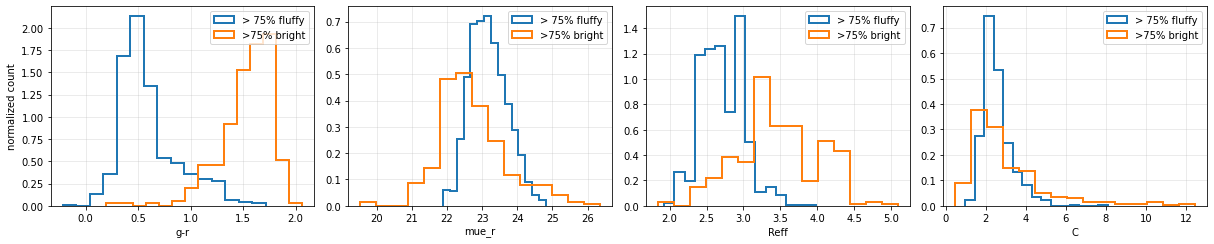

In [176]:
frames =[
    df_votes.query("`T0 % galaxy` > 75 & `T1 % fluffy` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T1 % bright` > 75")
]
labl = ['> 75% fluffy', '>75% bright']
plot_phot(frames, labl, 'Is the galaxy fluffy or is it bright?')
plot_distr(frames, labl)

In [108]:
t2cols = get_column_names('T2', df_votes); t2cols

['T2', 'T2 % impossible to say', 'T2 % white/blue', 'T2 % red/yellow']

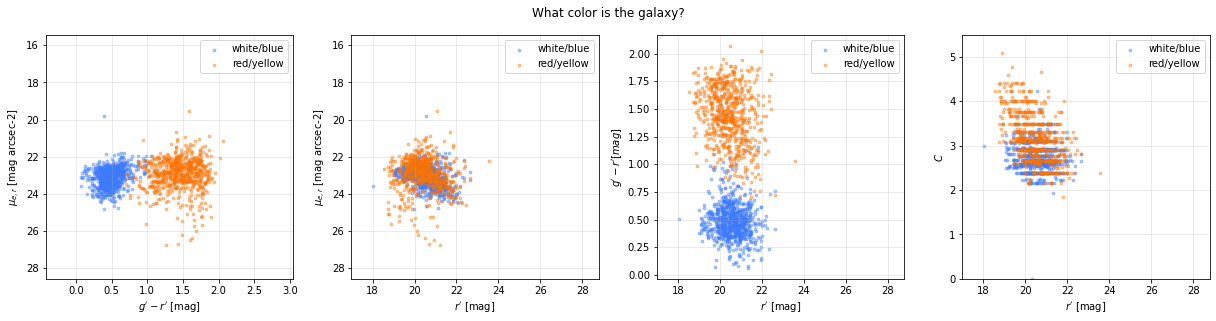

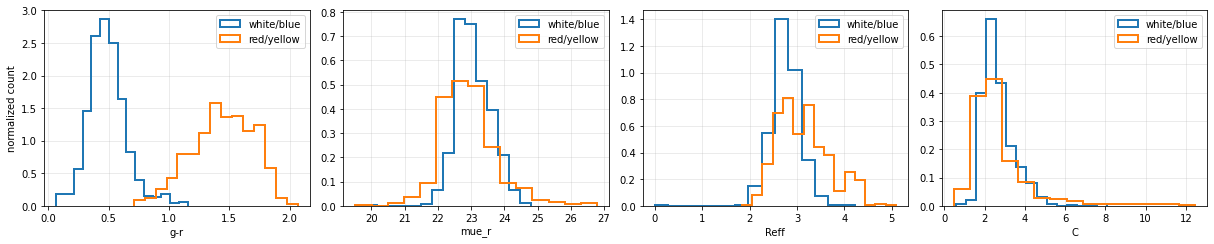

In [171]:
frames =  [
    df_votes.query("`T0 % galaxy` > 75 & `T2 % white/blue` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T2 % red/yellow` > 75")
]
labl = ['white/blue', 'red/yellow']
plot_phot(frames, labl, 'What color is the galaxy?')

plot_distr(frames,labl)

In [114]:
t3cols = get_column_names('T3', df_votes); t3cols

['T3', 'T3 % no/unsure', 'T3 % yes, a bright point', 'T3 % yes, a bulge']

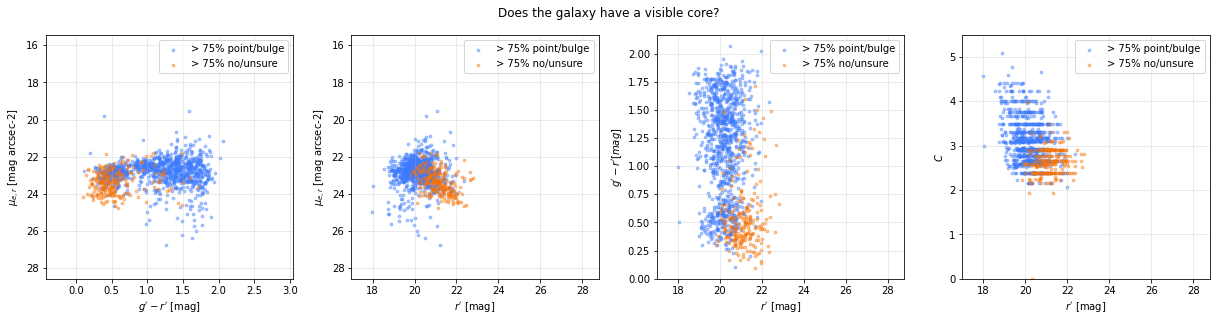

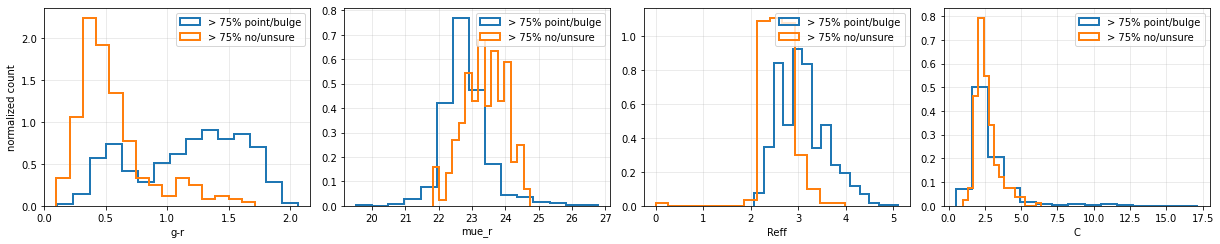

In [173]:
frames = [
    df_votes.query("`T0 % galaxy` > 75 & `T3 % yes, a bright point` + `T3 % yes, a bulge` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T3 % no/unsure` > 75")
]
labl = ['> 75% point/bulge', '> 75% no/unsure']
plot_phot(frames, labl, 'Does the galaxy have a visible core?')
plot_distr(frames, labl)

In [122]:
t5cols = get_column_names('T5', df_votes); t5cols

['T5',
 'T5 % smooth and fuzzy',
 'T5 % smooth and dense',
 'T5 % clumpy and/or featured']

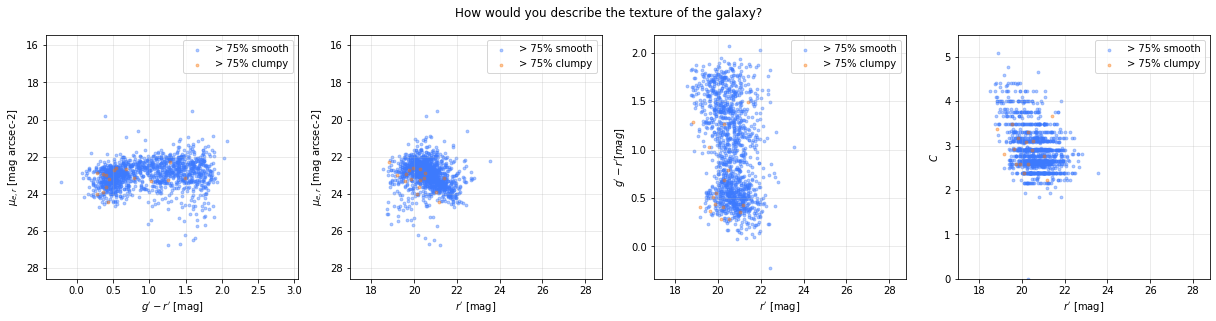

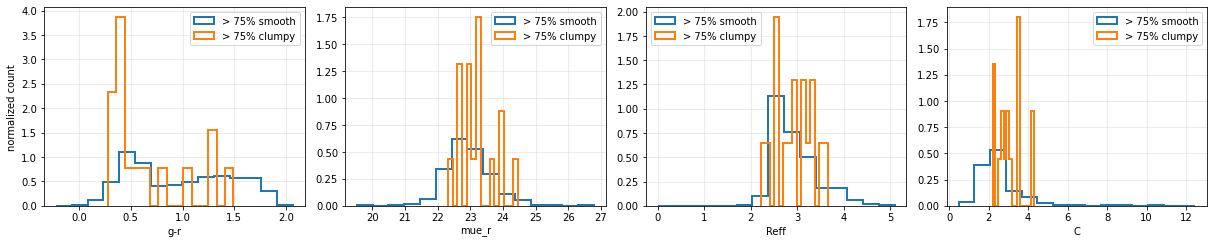

In [175]:
frames = [
    df_votes.query("`T0 % galaxy` > 75 & `T5 % smooth and fuzzy` + `T5 % smooth and dense` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T5 % clumpy and/or featured` > 75")
]
labl = ['> 75% smooth', '> 75% clumpy']
plot_phot(frames, labl, 'How would you describe the texture of the galaxy?')
plot_distr(frames, labl)

## Plot vote distributions for objects without properties:

In [126]:
no_props = df_votes.query('RA.isnull()')

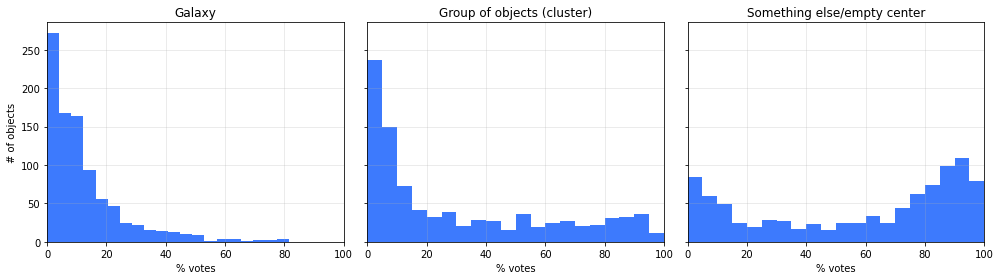

In [147]:
fig, fr = plt.subplots(1,3, figsize=(14,4), sharey=True)

labels = ['Galaxy', 'Group of objects (cluster)', 'Something else/empty center']
for i, ans in enumerate(t0cols[1:]):
    fr[i].hist(no_props[ans], density=False, bins=20, color='xkcd:lightish blue')
    fr[i].update(dict(
        xlim=[0,100],
        title=labels[i],
        xlabel="% votes",
    ))
    fr[i].grid(alpha=0.3)
        
fr[0].update(dict(ylabel="# of objects"))
fig.tight_layout()

plt.savefig('no props - votes.png', dpi=450, bbox_inches='tight')
plt.show()

In [151]:
no_props.shape[0], no_props.query('`T0 % galaxy` > 50').shape[0], no_props.query('`T0 % something else/empty center` > 50').shape[0]

(922, 19, 569)

We see that the vast majority of objects without photometric properties, get almost no votes for 'galaxy'.